# Data Exploration Exercise

Using whichever methods and libraries you prefer, create a notebook with the following:
1. Data preparation and Data exploration
2. Identify the three most significant data features which drive the credit risk
3. Modeling the credit risk
4. Model validation and evaluation using the methods that you find correct for the problem

Your solution should have instructions and be self-contained. For instance, If your choice is a python notebook, your notebook should install all the required dependencies to run it.

## Import and preparation  <a class="anchor" id="import"></a>

In [1]:
# display more than 1 output per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
%%capture 
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install pandas numpy sklearn matplotlib seaborn statsmodels

In [3]:
import pandas as pd
pd.options.display.max_columns = None # show all columns in a pandas dataframe

In [4]:
data = pd.read_csv('credit-g.csv')
data.head()

checking_status  duration                  credit_history  \
0              <0         6  critical/other existing credit   
1        0<=X<200        48                   existing paid   
2     no checking        12  critical/other existing credit   
3              <0        42                   existing paid   
4              <0        24              delayed previously   

               purpose  credit_amount    savings_status employment  \
0             radio/tv           1169  no known savings        >=7   
1             radio/tv           5951              <100     1<=X<4   
2            education           2096              <100     4<=X<7   
3  furniture/equipment           7882              <100     4<=X<7   
4              new car           4870              <100     1<=X<4   

   installment_commitment     personal_status other_parties  residence_since  \
0                       4         male single          none                4   
1                       2  female div/dep/mar          none                2   
2                       2         male single          none                3   
3                       2         male single     guarantor                4   
4                       3         male single          none                4   

  property_magnitude  age  other_payment_plans   housing  existing_credits  \
0        real estate   67                 none       own                 2   
1        real estate   22                 none       own                 1   
2        real estate   49                 none       own                 1   
3     life insurance   45                 none  for free                 1   
4  no known property   53                 none  for free                 2   

                  job  num_dependents own_telephone  foreign_worker class  
0             skilled               1           yes             yes  good  
1             skilled               1          none             yes   bad  
2  unskilled resident               2          none             yes  good  
3             skilled               2          none             yes  good  
4             skilled               2          none             yes   bad

## Data Exploration

In [5]:
### overview of the dataset
data.shape
data.columns
data.nunique() # unique values per column
print(f'class: {len(data[data["class"]=="good"])} "good" rows')
print(f'class: {len(data[data["class"]=="bad"])} "bad" rows')


(1000, 21)

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', ' other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       ' foreign_worker', 'class'],
      dtype='object')

checking_status             4
duration                   33
credit_history              5
purpose                    10
credit_amount             921
savings_status              5
employment                  5
installment_commitment      4
personal_status             4
other_parties               3
residence_since             4
property_magnitude          4
age                        53
 other_payment_plans        3
housing                     3
existing_credits            4
job                         4
num_dependents              2
own_telephone               2
 foreign_worker             2
class                       2
dtype: int64

class: 700 "good" rows
class: 300 "bad" rows


In order to visually inspect the data it's necessary to convert the datatype of the categorical features from string to category. This will also be necessary to train the model. Therefore the data will be formatted before further exploration.

# Outcome distribution

Ideally there would be an approximately equal number of outcome classes. In this dataset the split is 30% "bad" and 70% "good". The low number of bad credit risk assessments may limit the models ability to accurately predict a bad credit assessment relative to good assessments because of the limited training examples. This could result in more False Positives than would typically be expected.

# Data formating

In [6]:
# remove whitespace around column names
data.columns = [col.strip() for col in data.columns]

In [7]:
# Categorical variables have a limited and usually fixed number of possible values.
# Categorical data might have an order (e.g. ‘strongly agree', ‘agree’, 'disagree', 'strongly disagree') 

unordered_category_cols = [
    'credit_history',
    'purpose',
    'personal_status',
    'other_parties',
    'property_magnitude',
    'other_payment_plans',
    'housing',
    'job',
    'own_telephone',
    'foreign_worker',
    'class'
]

for col in unordered_category_cols:
    data[col] = data[col].astype('category')


ordered_category_cols = [
    ('checking_status', ["no checking", "<0", "0<=X<200", ">=200"], True),
    ('savings_status',['no known savings', '<100', '100<=X<500', '500<=X<1000', '>=1000'], True ),
    ('employment', ['unemployed', '<1', '1<=X<4', '4<=X<7', '>=7'], True),
]

for col in ordered_category_cols:
    data[col[0]]=pd.Categorical(data[col[0]], categories=col[1], ordered=col[2])

In [8]:
# convert categories to numnerical values, for SelectKBest
cat_columns = data.select_dtypes(['category']).columns
data[cat_columns] = data[cat_columns].apply(lambda x: x.cat.codes)

In [9]:
# all columns are now either categorical and encoded as an int (ordered or unordered) or numerical.
data.dtypes

checking_status            int8
duration                  int64
credit_history             int8
purpose                    int8
credit_amount             int64
savings_status             int8
employment                 int8
installment_commitment    int64
personal_status            int8
other_parties              int8
residence_since           int64
property_magnitude         int8
age                       int64
other_payment_plans        int8
housing                    int8
existing_credits          int64
job                        int8
num_dependents            int64
own_telephone              int8
foreign_worker             int8
class                      int8
dtype: object

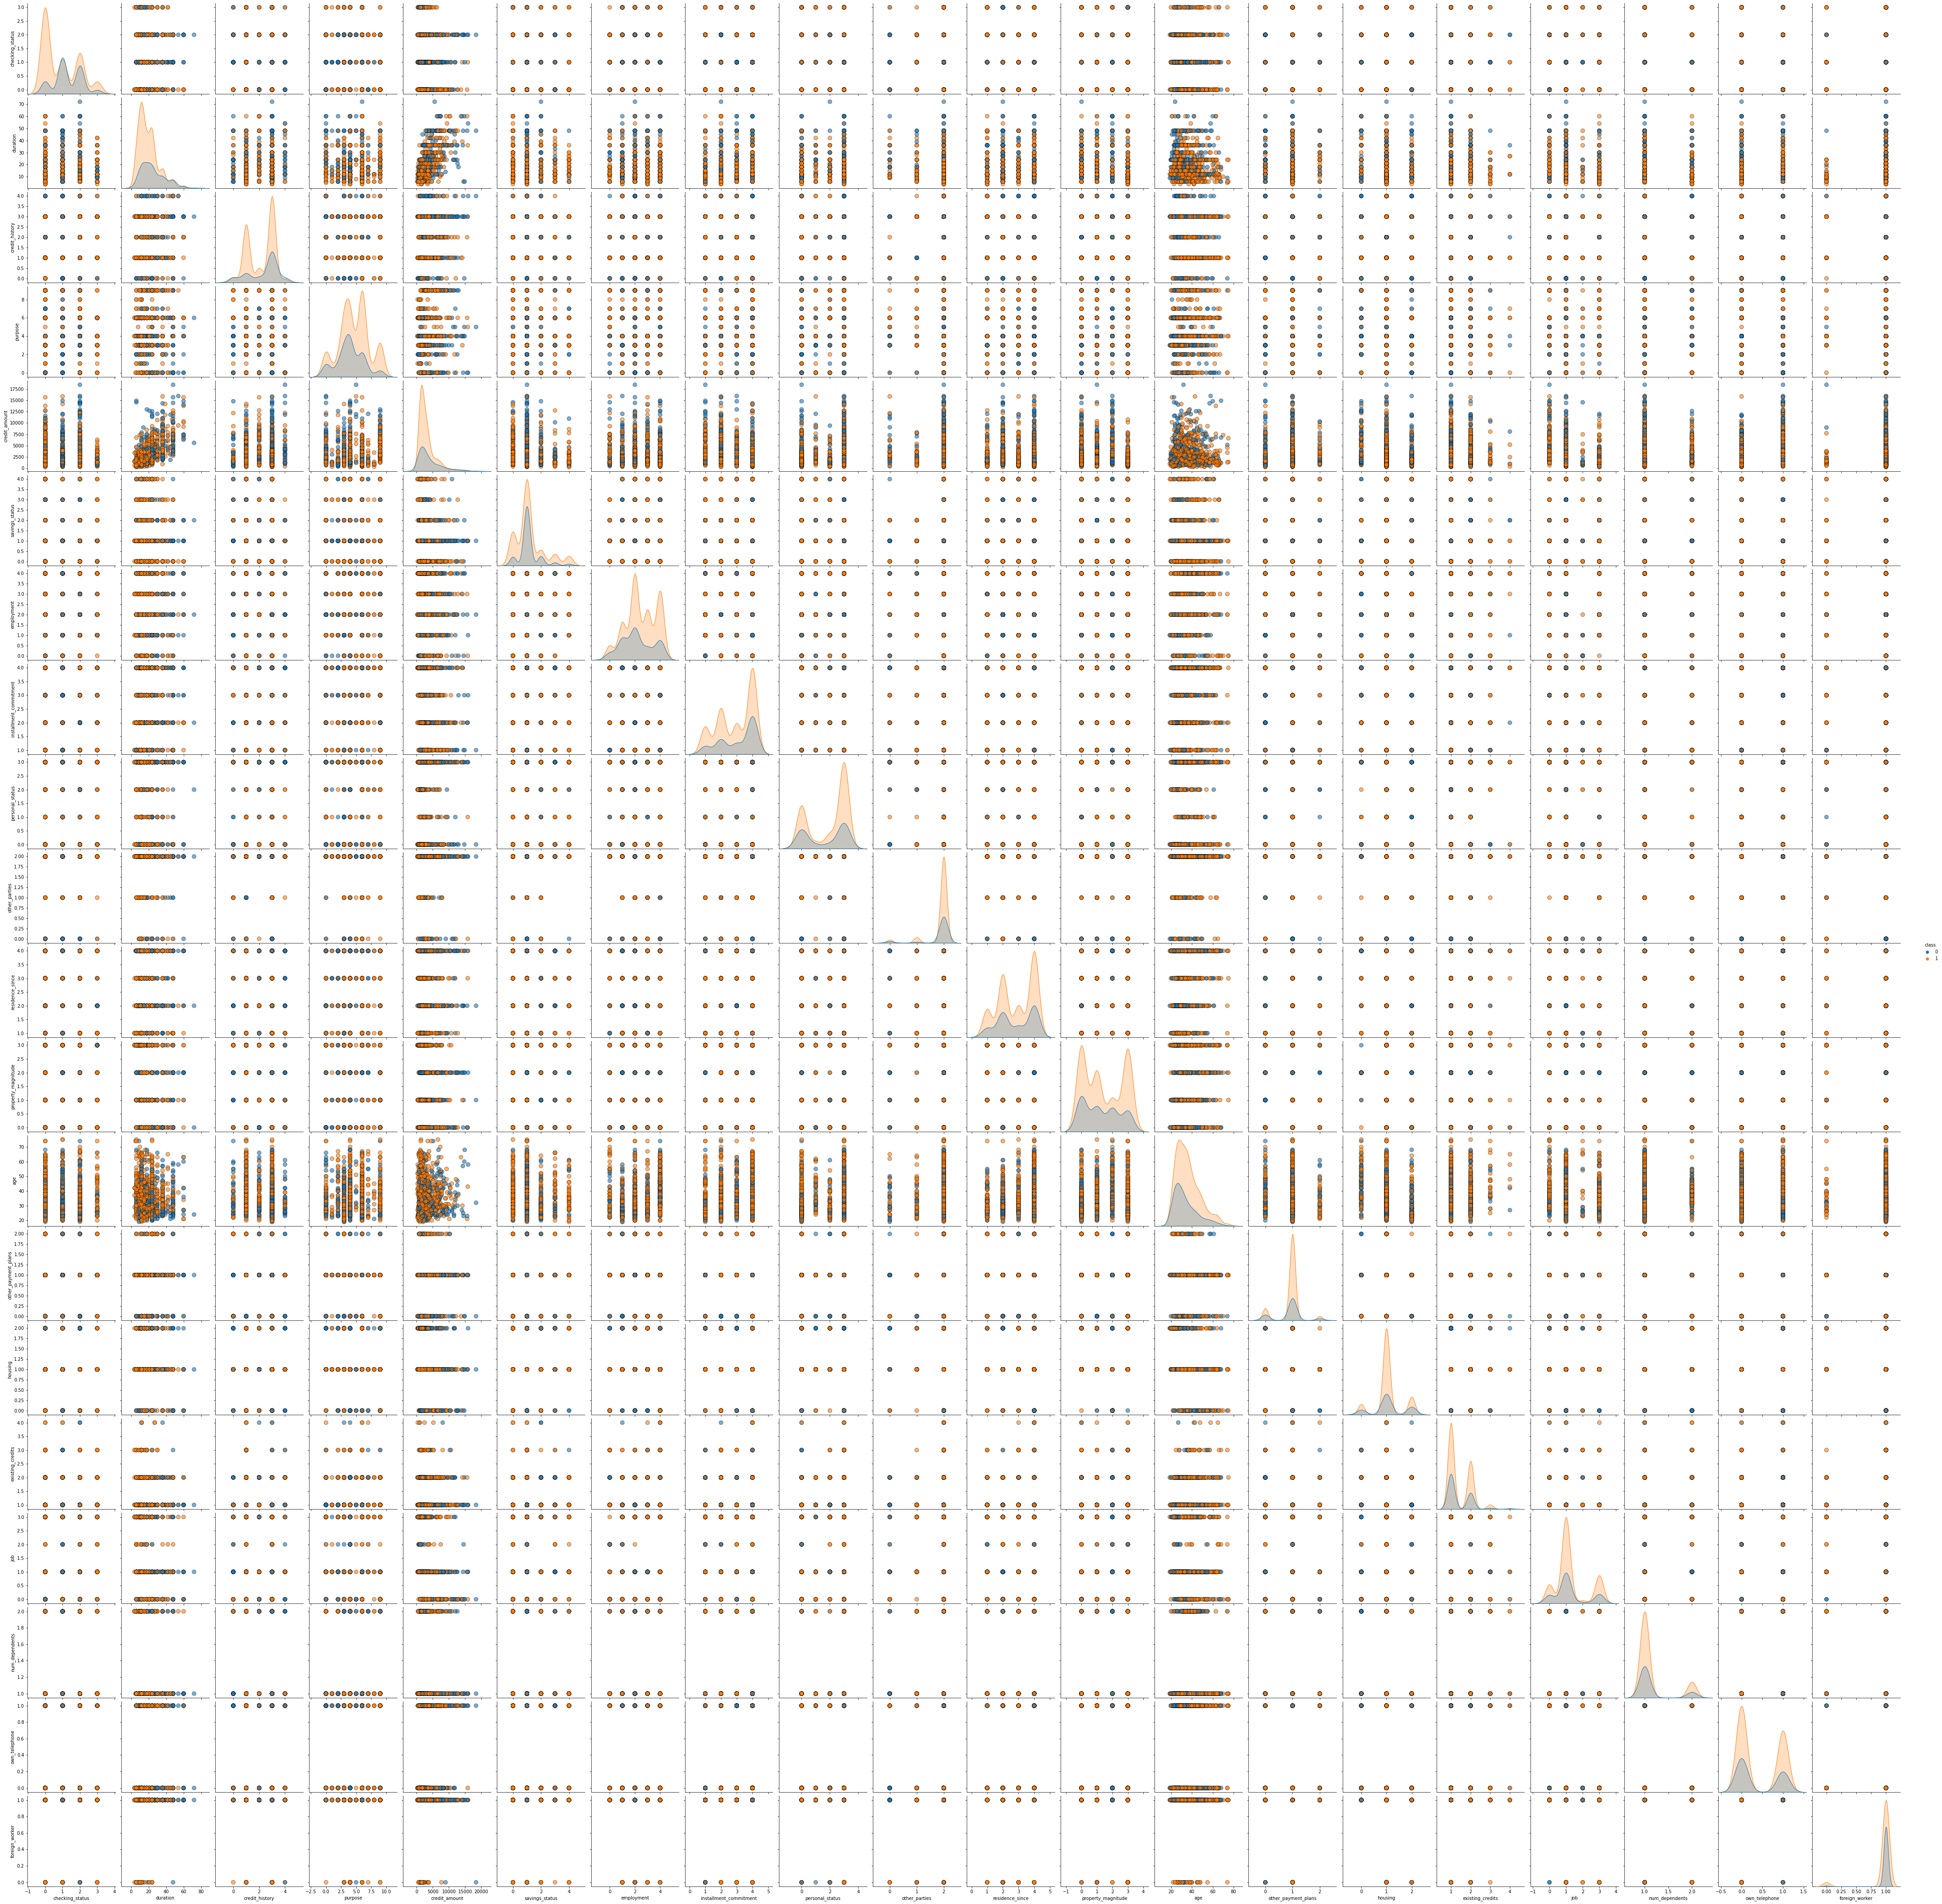

In [10]:
# this will take a while..
import seaborn as sns # Create the default pairplot
pairplot = sns.pairplot(
    data, 
    hue="class",
    diag_kind = 'kde',
    plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
    height = 3
)
fig = pairplot.fig
fig.savefig('pairplot.png', dpi=200) # default dpi is 100

## Visual inspection

The plot above compares each feature to each of the other features. The plots along the diagonal show the density plot of that feature, grouped by the value of the "class" feature that the model will predict. 

Inspecting the pairplot shows that each of the features has approximately the same distribution for each class value.

Of the continuous features, Credit Amount is most heavily left skewed. Age is also left skewed. 

If may improve the model to log transform `credit_amount` and `age`, particularly when predicting credit class when `credit_amount` or `age` values are in the middle of their respective ranges.

This could be done as follows:

```python
df['log_credit_amount'] = np.log10(df['credit_amount'])
```

In [11]:
# Split the data into features and outcome. 
X = data.iloc[:,0:20] # all columns except the "class" column
y = data.iloc[:,20] # only the "class" columns

### Check for multicoliniarity

Multicolinearity emerges when three or more model variables are highly correlated. Multicolinearity can emerge even when isolated pairs of variables are not colinear.

The Variance Inflation Factor (VIF) is a measure of colinearity among predictor variables. It is calculated by dividing the variance of all model betas by the variane of a single beta.

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [13]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif = vif.sort_values(by=['VIF Factor'], ascending=True)
vif.round(2)

VIF Factor                features
18        2.11           own_telephone
0         2.12         checking_status
11        2.50      property_magnitude
5         2.53          savings_status
16        3.56                     job
8         3.59         personal_status
3         4.41                 purpose
4         5.09           credit_amount
14        5.29                 housing
13        5.59     other_payment_plans
2         5.85          credit_history
6         5.85              employment
1         7.70                duration
15        7.89        existing_credits
10        8.71         residence_since
7         9.77  installment_commitment
17       11.59          num_dependents
12       13.19                     age
9        17.03           other_parties
19       23.45          foreign_worker

The results show that there is a significant amount of multicoliniarity in the dataset. 

We are about to identify the features that drive the credit risk decision the most, this will reduce colinearity, random noise and resource requirements.

Once we know which subset of features contribute most to the predictive value of the model we could check for colinearity within that subset. 

# Identify the three most significant features which drive credit risk

Feature selection is important because it removes non-informative or redundant predictors from the model. This improves model performance and reduces computational resource requirements. Various statistical tests could be used to find the most significant features, and can be placed into two braod categories - supervised (using domain knowledge and considering the relationship of the feature to the target variable) and unsupervised (which ignores the feature's relevance to the target variable).

The ANOVA F-value method is appropriate for numerical inputs and categorical outputs.  
The Chi^2 test is appropriate for categorical inputs with categorical outputs. 

Feature significance is evaluated using both methods:

In [14]:
X = data.iloc[:,0:20] # all columns except the "class" column
y = data.iloc[:,20] # only the "class" columns

In [15]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [16]:
%%capture

number_of_features = 3

selector=SelectKBest(score_func=f_classif, k=number_of_features)
selector.fit(X, y)
cols = selector.get_support(indices=True)
new_data = data.iloc[:,cols]

In [17]:
list(zip(data.columns, selector.scores_))

[('checking_status', 40.63119963993437),
 ('duration', 48.33379013278894),
 ('credit_history', 9.489998635672789),
 ('purpose', 19.418504770210543),
 ('credit_amount', 24.48236587628224),
 ('savings_status', 1.146283193972111),
 ('employment', 13.612738944563556),
 ('installment_commitment', 5.259417069804338),
 ('personal_status', 8.065142296224387),
 ('other_parties', 0.8078988150796316),
 ('residence_since', 0.008786500367455853),
 ('property_magnitude', 3.0868468501366393),
 ('age', 8.356994513185738),
 ('other_payment_plans', 2.903710080054703),
 ('housing', 0.3724629282658375),
 ('existing_credits', 2.091652268267933),
 ('job', 1.0719338803531462),
 ('num_dependents', 0.009071242887395496),
 ('own_telephone', 1.3288905963475326),
 ('foreign_worker', 6.769174257614171)]

In [18]:
%%capture

number_of_features = 3

selector=SelectKBest(score_func=chi2, k=number_of_features)
selector.fit(X, y)
cols = selector.get_support(indices=True)
new_data = data.iloc[:,cols]

In [19]:
list(zip(data.columns, selector.scores_))

[('checking_status', 35.75895533038388),
 ('duration', 321.0307953062103),
 ('credit_history', 4.801154531213124),
 ('purpose', 24.92485450915428),
 ('credit_amount', 58262.49000691708),
 ('savings_status', 0.900360144057623),
 ('employment', 8.232742090124631),
 ('installment_commitment', 2.204619351945284),
 ('personal_status', 7.782240478726106),
 ('other_parties', 0.08584698616853026),
 ('residence_since', 0.0037660055234744255),
 ('property_magnitude', 3.2592592592592653),
 ('age', 30.200309190237782),
 ('other_payment_plans', 0.5672330606251323),
 ('housing', 0.09821706460361804),
 ('existing_credits', 0.49551561918299514),
 ('job', 0.7536816924572033),
 ('num_dependents', 0.0010307153164296021),
 ('own_telephone', 0.7925506836397938),
 ('foreign_worker', 0.24927063244820177)]

The three most significant features are:

* Duration (ANOVA: 48, Chi2: 321)
* Checking Status (ANOVA: 40, Chi2: 36)
* Credit Amount (ANOVA: 24, Chi2: 58262)

The most significant feature is Duration, followed by Checking Status and Credit Amount. This makes sense intuitively, because Duration and Credit Amount must be proportional to risk. Checking Status is unfamiliar and I don't know what it means, in a real scenario I would speak to stakeholders or team members to learn more about this feature.

In [20]:
selected_features = ['credit_amount', 'duration', 'checking_status']
X = X[selected_features]

In [21]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif = vif.sort_values(by=['VIF Factor'], ascending=True)
vif.round(2)

VIF Factor         features
2        1.69  checking_status
0        3.84    credit_amount
1        4.46         duration

Using an arbitrary but common VIF threshold value of 5, we see that none of the 3 most significant features are colinear. Hoever `duration` is close with a score of 4.46 and `credit_amount` is second with 3.84. Intuitively, it seems reasonable that `credit_amount` and `duration` might have some colinearity, as they could be generally expected to be inversely correlated to each other. - You could borrow more for a short period of time than you could for a longer duration.

#### Optimize the number of features to use

After an initial demonstration of the metrics used to assess model performance, the optimal number of features to use will be investigated.

In [22]:
# used later 
features_scored = list(zip(data.columns, selector.scores_))
features_scored.sort(key=lambda x:x[1], reverse=True)

# Modeling Credit Risk
We use logistic regression because this is a binary classification problem with multiple predictor variables that are mostly independent.

Logistic Regression is a reasonable first choice of model type to use, but in a longer project we could use multiple model types and compare their performance against one another, then select the classifier which performs the best. Other types could include k-nearest neighbors, decision trees, or Support Vector Machines (SVMs).

Logistic regression makes the following assumptions:

1. No multicollinearity among the independent variables. Multicollinearity can be tested using the Variance Inflation Factor (VIF).
2. No influential outliers
3. Independence of errors (residuals) or no significant autocorrelation. The residuals should not be correlated with each other. This can be tested using the Durbin-Watson test, but this is out of scope for this exercize.
4. The sample size should be large (at least 50 observations per independent variables are recommended) -> 20 $\times$ 50 = 1000

## Splitting the data into training, validation and testing sets

A validation set is used in addition to training and testing. This is because I expect to optimize model parameters by comparing the performance of different models using a dataset they weren't trained on. If this were the same dataset that the final performance metric was based on then the model would be implicitely overfitted. 

Instead, the performance of optimizations will be quantified using the validation set, and the optimal models performance will be quantified using the testing set. 

This gives better prediction of actual performance against new production data (outside the available dataset) than only using training and testing data sets.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [24]:
# 70% training, 15% validation, 15% testing is reasonable.

# use train_test_split twice, first to split out a testing set, then to split the remainder into validation and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.176, random_state=0)

assert len(X_train) == len(y_train) and len(X_validation) == len(y_validation) and len(X_test) == len(y_test)

print(f'Training examples: {len(X_train)}')
print(f'Validation examples: {len(X_validation)}')
print(f'Testing examples: {len(X_test)}')

Training examples: 700
Validation examples: 150
Testing examples: 150


In [25]:
from collections import Counter

y_train_status = Counter(y_train)
ratio = y_train_status[0]/(y_train_status[0]+y_train_status[1])

print(f"training set has {y_train_status[0]} negative values and {y_train_status[1]} positive values ")
print(f"result ratio is approximatley {int(100*round(ratio,2))}:{int(100*round(1-ratio,2))}")

training set has 222 negative values and 478 positive values 
result ratio is approximatley 32:68


The training set has over twice as many positive values as negative values. This is similar to the complete data set which has 700 "good" credit class examples and 300 "bad" credit class examples.

## Training the logistic regression model

The model is trained on the training dataset.

In this simple first case, we evaluate performance (discussed below) using the test data set. After an initial discussion of the results, the performance of different models is evaluated using a validation data set.

In [26]:
logreg = LogisticRegression();
logreg.fit(X_train,y_train);
y_pred = logreg.predict(X_test);

## Model evaluation 

A model could be evaluated in many different ways, each with different strengths and weaknesses depending on the characteristics of the data and the relevant domains. 

Where possible, its preferable to use only a single metric to quantify and compare model performance, because its simpler (and less error prone) than if there are multiple metrics to consider.

There are 4 basic categories of results that the model could produce:
1. True Positives (TP)
2. False Positives (FP)
3. True Negatives (TN)
4. False Negatives (FN)

These can be combined to calculate the model's Precision and Recall:

* Optimizing **Precision** minimizes false positives but ignores false negatives. 
* Optimizing **Recall** minimizes false negatives but ignores false positives. 

```
P = True Positives / (True Positives + False Positives) -> if False Positives are 0, P=1
R = True Positives / (True Positives + False Negatives) -> if False Negatives are 0, R=1
```


Precision is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. It is the ability of the classifier not to label as positive a sample that is negative.

High precision implies fewer false positives.

`Precision = True Positives / (True Positives + False Positives)`

Recall is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. It quanitifies the ability of the model to find all the positive samples.

High recall implies fewer false negatives.

`Recall = True Positives / (True Positives + False Negatives)`


An ideal model will have good precision and recall. The F-Score provides a way to combine precision and recall into a single measure that captures both properties.

```
F-Measure = (2 * Precision * Recall) / (Precision + Recall) 
```

The influence of precision and recall relative to each other can be changed by adding a coefficient into the F-measure. Further discussion of this is outside the scope of this brief exercise except to say that F1 (above) has beta=1 and places equal weight on precision and recall. F2 (beta=2) places less weight on precision and more on recall, and F0.5 emphasizes precision over recall.

Other metrics to consider include `Precision Recall curves` and the `Receiver Operating Characteristic curve` (ROC). 

ROC curves are more informative when evaluating datasets with equal proportion of positive and negative results. In a skewed dataset such as this, ROC can be overly optimistic and Precision-Recall curves are more reliable. 

Therefore after briefly demonstrating the confusion matrix we consider the average precision and recall instead of comparing the area under the ROC curve for different models.

## Summary of results with the 3 most significant features

In [27]:
from sklearn import metrics

print(f"Precision: {round(metrics.precision_score(y_test, y_pred),3)}")
print(f"Recall: {round(metrics.recall_score(y_test, y_pred),3)}")
print(f"F1: {round(metrics.f1_score(y_test, y_pred),3)}")

Precision: 0.789
Recall: 0.91
F1: 0.845


## Confusion Matrix

The confusion matrix simply shows the number of True Positives, True Negatives, False Positives and False Negatives that the model predicted.

These results are based on the testing data set. This model was trained on the training dataset. 

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

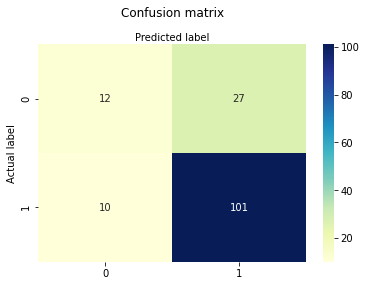

In [29]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top");
plt.title('Confusion matrix', y=1.1);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');

## Precision-Recall Curve


Reviewing both precision and recall is useful in cases where there is an imbalance in the observations between the two classes. This is because the large number of class 1 ("good") examples means we are less interested in the skill of the model at predicting this correctly, e.g. high true positives, and instead are more concerned with how the model can predict true negatives (where credit class is "bad"). The confusion matrix above shows that the largest error group is False Positives, which is expected because the model has relatively few examples of negative examples compared to positive. This is why the precision is lower than the recall.

A no-skill classifier is one that cannot discriminate between the classes and would predict a random or constant class in all cases. This creates a minimum precision called the "no-skill" line. Its value is the ratio of positive cases in the dataset. For our training data set it is 0.687. (Note it is not 0.7, due to the random selection of the training set.)

The `Precision Recall` metric is a useful measure of success of prediction when the classes are very imbalanced, as they in this case. A precision-recall curve focuses on the performance of a classifier on the positive class.

The precision-recall curve shows the tradeoff between precision and recall for different probability thresholds, which we refer to but do not investigate in detail in this limited exercise.

The threshold is the probability at which a "good" or "bad" label is applied. The default threshold is 0.5, which means that if the model calculates the probability of an observation being "good" as more than 0.5 then it applies the label "good", otherwise it applies the label "bad". This threshold probability can be varied and the impact on model performance quantified.

A high area under the curve represents both high recall and high precision. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many positive results, but most of its predicted labels are incorrect when compared to the training labels. 

A system with high precision but low recall is the opposite, returning very few positive results but most of them are correct. An ideal system with high precision and high recall will identify almost all positive cases, with all results labeled correctly.

AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight.

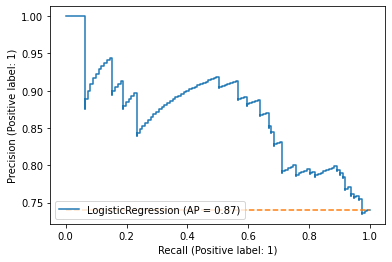

In [30]:
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve

disp = plot_precision_recall_curve(logreg, X_test, y_test)

no_skill = len(y_test[y_test==1]) / len(y_test) # the proportion of results that are "good"
disp.ax_.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill');

# Summary

Using the 3 most signficant features we have the following results:

F1: 0.845
Precision-Recall AUC: 0.87

The model could be improved by finding the optimal number of features to consider.

## Improving the model by optimizing the number of features

The code below iterates through the available features from most significant to least, adding an additional factor in each loop.

Each loop generates a new logistic regression model and trains it on the same training data set. Its performance is evalulated using the same validation data set. The results are summarized in the "results" dataframe and discussed below. 

Due to the very small amount of data, changing the random_state value can produce results with different trends. Therefore the first recommendation to improve the model is to get more data. This is also discussed below.

In [31]:
%%capture

X = data.iloc[:,0:20] # start with all the features

max_features = 10
i = 1
results = [] 

while i <= max_features:
    print(i)
    X = data.iloc[:,0:20] # all columns except the "class" column
    
    # select the features we want to use in the model
    cols = [j[0] for j in features_scored[:i]] # features_scored is sorted descending
    
    # remake the training sets with the correct features
    X_train, X_test, y_train, y_test = train_test_split(X[cols], y, test_size=0.15, random_state=0) # random state is specified, ensuring same groups for each test
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.176, random_state=0)

    logreg = LogisticRegression();
    logreg.fit(X_train, y_train);
    y_pred = logreg.predict(X_validation); # use validation this time (not test) because we will compare different models
    
    disp = plot_precision_recall_curve(logreg, X_validation, y_validation)

    fscore = (2 * disp.precision * disp.recall) / (disp.precision + disp.recall)
    
    lr_f1 = metrics.f1_score(y_validation, y_pred)

    results.append({'i': i, 'f1': lr_f1, 'AUC': disp.average_precision})
    i += 1
    
results = pd.DataFrame(results)
results.set_index("i", inplace=True)

In [32]:
results

f1       AUC
i                     
1   0.852590  0.740326
2   0.850202  0.810601
3   0.859438  0.855195
4   0.832653  0.826140
5   0.825911  0.873120
6   0.825911  0.874651
7   0.811475  0.876348
8   0.832653  0.878845
9   0.826446  0.889659
10  0.825000  0.881342

## Optimization Results

The results show that the highest F1 score (which places equal emphasis on Precision and Recall) of 0.859 is obtained using a logistic regression model that uses the three most significant features (Credit Amount, Checking Status and Duration).

Due to the small data sets (700 examples in the training set, 150 in each of the validation and testing sets) the results can vary significantly when a different random number seed is used to generate the 3 datasets. 

Whilst the table above shows that AUC increases with number of features, the increase is small (0.9% from 5 to 10 features) and sensitive to the random number seeds - if a different seed is used, the same trend is not observed. Therefore, whilst Recall-Precision curves are a useful tool in imbalanced datasets, the small size of the dataset being used in this analysis creates variation that wouldnt be observed in larger datasets.


## Model performance using Test Data Set

We test the performance of the model chosen in the optimization stage. In this stage we use the testing dataset, because this provides a more reliable indication of how the model might perform with (new) production data compared to using the results from the validation dataset. 

LogisticRegression()

0.8451882845188285

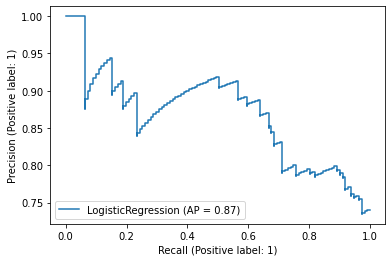

In [33]:
cols = ['duration', 'checking_status', 'credit_amount']
X_train, X_test, y_train, y_test = train_test_split(X[cols], y, test_size=0.15, random_state=0) # random state is specified, ensuring same groups for each test
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.176, random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test) # use validation this time (not test) because we will compare different models
    
disp = plot_precision_recall_curve(logreg, X_test, y_test)
#fscore = (2 * disp.precision * disp.recall) / (disp.precision + disp.recall)
#fscore

metrics.f1_score(y_test, y_pred)

### Recommendations

1. Obtain more training data

   This will reduce the influence of randomness on the model scores.

2. Use a credit score instead of just a "good" or "bad" decision. 

    The "good" or "bad" status is probably the result of a threshold being applied to a metric. Accessing the underlying metric would provide more detail and help train a more reliable model. 

3. Consider additional features

    This would require domain expertise and additional context.


